# **Introduction to Probabilistic Graphical Models and Deep Generative Models - Homework 2**: IWAE for binarised MNIST

*Authors : Paule GRANGETTE and Dorian GAILHARD*

In this assignment, you'll play a bit with a VAE on a binarised version of MNIST

# Loading useful stuff

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import scipy as sp

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

# Loading MNIST and binarising it

In [2]:
(train_images_nonbinary, y_train), (test_images_nonbinary,  y_test) = tf.keras.datasets.mnist.load_data()

train_images_nonbinary = train_images_nonbinary.reshape(train_images_nonbinary.shape[0], 28*28)
test_images_nonbinary = test_images_nonbinary.reshape(test_images_nonbinary.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int64)
y_test =tf.cast(y_test, tf.int64)

11490434/11490434 [==============================] - 0s 0us/step


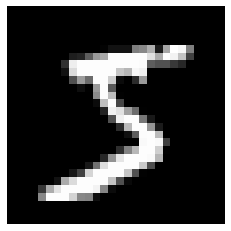

In [3]:
plt.imshow(train_images_nonbinary[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

Then we binarise the data. There are many ways to do that. Here, we simply round the numbers, following the [TF tutorial on convolutional VAEs](https://www.tensorflow.org/tutorials/generative/cvae).

In [4]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images_nonbinary/255.
test_images = test_images_nonbinary/255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

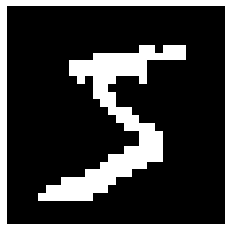

In [5]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

# Specifying our graphical model

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow \mathbb{[0,1]}^p$ is a function (called the **decoder**) parametrised by a deep neural net. This neural net will be defined as a keras sequential model.

In [40]:
d = 50 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

In [41]:


decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(d,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

Note that the decoder needs to output probabilities, which can be constrained using a sigmoid final layer. However, it is generally better (i.e. computationnaly more stable) to work with [logits](https://stackoverflow.com/questions/34240703/what-are-logits-what-is-the-difference-between-softmax-and-softmax-cross-entrop) than probabilities, when doing deep learning. For instance, all the distributions of TensorFlow probability or Pytorch distributions that use probabilities as parameters (e.g. [Bernoulli](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Bernoulli), [categorical](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Categorical) or [binomial](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Binomial)) can use $\texttt{logits}$ or $\texttt{probs}$ as arguments. It is generally better to use  $\texttt{logits}$. This is why this keras model for the decoder does not output probabilities, but logits.





**1. Implement a function that performs ancestral sampling for this deep latent variable model, and show 5 sampled images from the initialised model. Of course, we expect these samples to look like random noise, since we have not trained our model yet.**

In [42]:
def ancestral_sampling(n_samples, p_z, pi):
    s = tfd.Sample(p_z, sample_shape=n_samples)
    samples = s.sample()
    par = pi(samples)
    par = tf.squeeze(par)
    bin = tfd.Binomial(total_count=n_samples, logits=par)
    xs = tfd.Sample(bin, sample_shape=1)
    x = xs.sample()
    x = tf.squeeze(x)
    return x

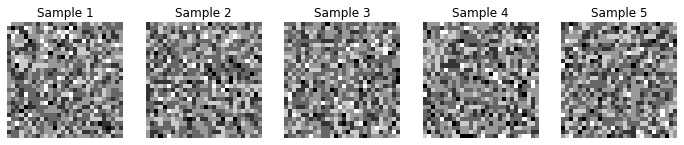

In [43]:
x = ancestral_sampling(5, p_z, decoder) 

fig, ax = plt.subplots(1,5, figsize=(12,12))
for i in range(5):
  ax[i].imshow(x[i, :], cmap='gray')
  ax[i].set_title("Sample {}".format(i+1))
  ax[i].axis('off')
plt.show()

## Encoder

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$ 
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [44]:
encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28,1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(2*d), # 2*d because we need both the mean and the diagonal of the covariance of q(z|x)
        ]
    ) 

## The IWAE objective

The **IWAE objective** is defined as
$$
\mathcal{L}_K (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z}_{i1},\ldots,\mathbf{z}_{iK} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{1}{K} \sum_{k=1}^K \frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_{ik}){p(\mathbf{z}_{ik})}}{{q_{\boldsymbol{\gamma}}(\mathbf{z}_{ik}|\mathbf{x}_i)}} \right]
$$

**2. Compute an unbiased estimate of the IWAE bound of our initialised model.** 


In [45]:
def estimate_IWAE_bound(X, K, prior, encoder, decoder):
    IWAE_obj = 0
    n_samples = X.shape[0]
    X = tf.reshape(X, shape=(-1,28,28))
    #get mean and covariance from the encoder output
    mean, cov = tf.split(encoder(X), num_or_size_splits=2, axis=1)
    pos_cov = tf.math.softplus(cov)
    bound = 0
    for i in range(n_samples):
      #compute the distribution of q_gamma
      q_gamma = tfd.Independent(tfd.Normal(loc = mean[i], scale = tf.cast(pos_cov[i], tf.float32)), reinterpreted_batch_ndims=1)
      #sample from q_gamma
      zxs = tfd.Sample(q_gamma, sample_shape=K)
      z_given_x = zxs.sample()
      #compute log_q_gamma(z_ik|x_i)
      log_q_z_given_x = q_gamma.log_prob(z_given_x)
      #compute prior log_p(z_ik)
      log_p_z = prior.log_prob(z_given_x)
      #compute p(x_i|z_ik)
      logits = tf.reshape(tf.squeeze(decoder(z_given_x)), shape=(K,-1))
      bin = tfd.Bernoulli(logits=logits)
      log_p_x_given_z_i = bin.log_prob(tf.cast(tf.reshape(X[i,:], shape=(1,-1)), tf.float32))
      bound_i = 0
      log_product_k = log_p_z - log_q_z_given_x + tf.reduce_sum(log_p_x_given_z_i, axis=-1)
      log_sum_exp_log_product = tf.math.reduce_logsumexp(tf.reduce_mean(log_product_k))
      bound_i += tf.get_static_value(log_sum_exp_log_product)
      bound += bound_i
    return bound

In [47]:
iwae = estimate_IWAE_bound(train_images[:100], 100, p_z, encoder, decoder)
print('The IWAE bound for the 100 first image of the training dataset is : ', iwae)

The IWAE bound for the 100 first image of the training dataset is :  -55230.84393310547


## Using a pre-trained model

We are giving you now a pre-trained model ($\hat{\theta}$,$\hat{\gamma}$). We can load these pre-trained weights by running the following cell:



In [29]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
decoder = tf.keras.models.load_model('/content/drive/MyDrive/MVA/PGM/DM2/trained_decoder.h5')
encoder = tf.keras.models.load_model('/content/drive/MyDrive/MVA/PGM/DM2/trained_encoder.h5')

**3. Show a few samples from this pre-trained model. Check that they look nicer than the samples from the untrained model. Check also that the IWAE bound of the pre-trained model is larger than the one of the trained model.**

In [31]:
d = 10 # dimension of the latent space

p_z = tfd.Independent(tfd.Normal(loc = tf.zeros(d, tf.float32), scale = tf.ones(d, tf.float32)),reinterpreted_batch_ndims=1)  # that's the prior

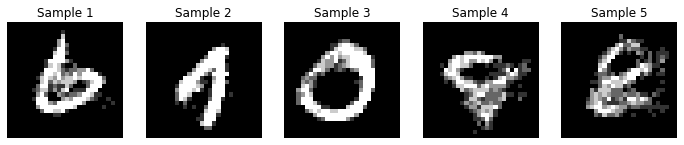

In [32]:
x = ancestral_sampling(5, p_z, decoder) 

fig, ax = plt.subplots(1,5, figsize=(12,12))
for i in range(5):
  ax[i].imshow(x[i, :], cmap='gray')
  ax[i].set_title("Sample {}".format(i+1))
  ax[i].axis('off')
plt.show()

In [39]:
iwae = estimate_IWAE_bound(train_images[:100], 100, p_z, encoder, decoder)
print('The IWAE bound for the 100 first image of the training dataset is : ', iwae)

The IWAE bound for the 100 first image of the training dataset is :  -25897.44078063965


We can see that the IWAE bound for the pretrained model is larger than for the initial random noise model.

**4. Derive and implement an importance sampling estimate to approximate the posterior mean of each data point:
$$\mathbb{E}[\mathbf{z} | \mathbf{x}_i] = \int \mathbf{z} p(\mathbf{z}|\mathbf{x}_i)d\mathbf{z}.$$
Visualise these 10-dimensional embeddings using a scatter plot.**

We are going to derive an importance sampling estimate through an approximation of a an expectation conditionned by a Gaussian distribution.

$$\mathbb{E}[z|x_i] = ∫zp(z|x_i)dz \approx ∫zq_{\gamma}(z|x_i)dz = ∫z\frac{q_{\gamma}(z|x_i)}{q(z|x_i)}q(z|x_i)dz ≈ \frac{1}{K}\sum_{k=1}^K \frac{z_kq_{\gamma}(z_k|x_i)}{q(z_k|x_i)}$$

where $K$ is the number of samples used to estimate $\mathbb{E}[z|x_i]$ and we will sample our distribution from $q$ for which we will test deux different distributions: a Student's distribution of degree of freedom 3 and a Gaussian just like $q_{\gamma}$.

In [25]:
from sklearn.decomposition import PCA



*   Students' distribution



In [27]:
def importance_sampling_estimate(X, K):
  n = X.shape[0]
  x = tf.reshape(X, [n, 28, 28, 1])
  mu, cov = tf.split(encoder(x), num_or_size_splits=2, axis=1)
  pos_cov = tf.math.softplus(cov)
      
  q_gamma = tfd.Normal(loc = mu, scale = tf.cast(pos_cov, tf.float32))
  q_ref = tfp.distributions.StudentT(df=3, loc=mu, scale=pos_cov, validate_args=True)

  z_given_x = q_ref.sample(sample_shape=K)
  q_gamma_z_x = q_gamma.prob(z_given_x)
  q_gamma_z_x = tf.reduce_mean(q_gamma_z_x, axis=-1)
  q_ref_z_x = q_ref.prob(z_given_x)
  q_ref_z_x = tf.reduce_mean(q_ref_z_x, axis=-1)

  product_distrib_factor = tf.math.divide(q_gamma_z_x, q_ref_z_x)
  product_distrib_factor = tf.reshape(tf.repeat(product_distrib_factor, d, axis=-1), [K, n, d])
  product = tf.math.multiply(z_given_x, product_distrib_factor)
  estimation = tf.reduce_mean(product, axis=0)
  return estimation


In [28]:
posterior_train = importance_sampling_estimate(train_images[:25000], 1000)
posterior_test = importance_sampling_estimate(test_images, 1000)

In [29]:
#reduction via PCA in dimension 2
pca = PCA(n_components=2, random_state=42)
posterior_train_pca = pca.fit_transform(posterior_train)
posterior_test_pca = pca.transform(posterior_test)

Text(0.5, 1.0, 'Posterior mean estimate via PCA (test)')

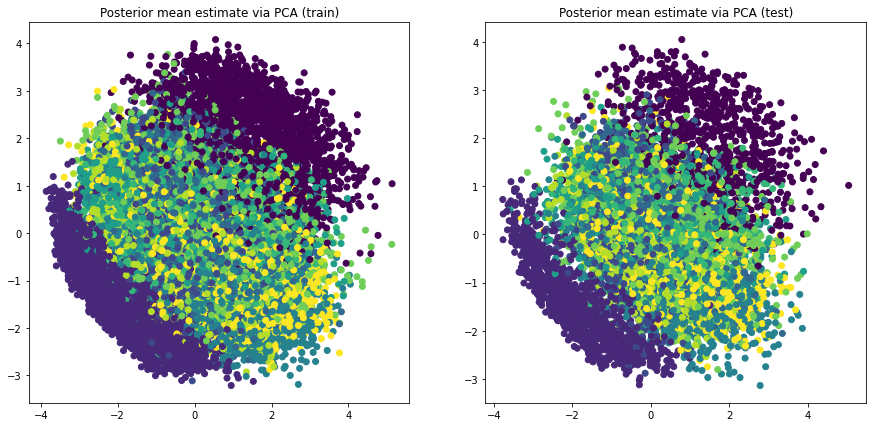

In [31]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(posterior_train_pca[:,0], posterior_train_pca[:,1], c=y_train[:25000])
ax[0].set_title('Posterior mean estimate via PCA (train)')
ax[1].scatter(posterior_test_pca[:,0], posterior_test_pca[:,1], c=y_test)
ax[1].set_title('Posterior mean estimate via PCA (test)')



*   With Gaussian posterior



In [32]:
def importance_sampling_estimate(X, K):
  n = X.shape[0]
  x = tf.reshape(X, [n, 28, 28, 1])
  mu, cov = tf.split(encoder(x), num_or_size_splits=2, axis=1)
  pos_cov = tf.math.softplus(cov)
      
  q_gamma = tfd.Normal(loc = mu, scale = tf.cast(pos_cov, tf.float32))
  q_ref = tfd.Normal(loc = mu, scale = tf.cast(pos_cov, tf.float32))

  z_given_x = q_ref.sample(sample_shape=K)
  q_gamma_z_x = q_gamma.prob(z_given_x)
  q_gamma_z_x = tf.reduce_mean(q_gamma_z_x, axis=-1)
  q_ref_z_x = q_ref.prob(z_given_x)
  q_ref_z_x = tf.reduce_mean(q_ref_z_x, axis=-1)

  product_distrib_factor = tf.math.divide(q_gamma_z_x, q_ref_z_x)
  product_distrib_factor = tf.reshape(tf.repeat(product_distrib_factor, d, axis=-1), [K, n, d])
  product = tf.math.multiply(z_given_x, product_distrib_factor)
  estimation = tf.reduce_mean(product, axis=0)
  return estimation

In [33]:
posterior_train = importance_sampling_estimate(train_images[:10000], 1000)
posterior_test = importance_sampling_estimate(test_images, 1000)

In [34]:
#reduction via PCA in dimension 2
pca = PCA(n_components=2, random_state=42)
posterior_train_pca = pca.fit_transform(posterior_train)
posterior_test_pca = pca.transform(posterior_test)

Text(0.5, 1.0, 'Posterior mean estimate via PCA (test)')

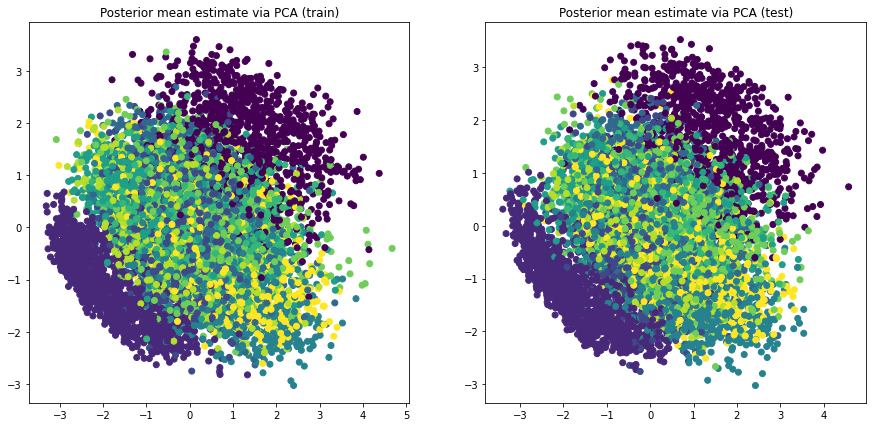

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,7))
ax[0].scatter(posterior_train_pca[:,0], posterior_train_pca[:,1], c=y_train[:10000])
ax[0].set_title('Posterior mean estimate via PCA (train)')
ax[1].scatter(posterior_test_pca[:,0], posterior_test_pca[:,1], c=y_test)
ax[1].set_title('Posterior mean estimate via PCA (test)')

We can see that the results are the same whatever the distribution of reference.